# Libraries

In [602]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preprocessing

## Import & First look

In [603]:
#data0 = pd.read_csv('./EURUSD1440.csv',sep='\t',names=['time','open','high','low','close','volume'])

data = pd.read_csv('../data/EUR_USD Historical Data.csv')
changes = [ float(i[:-1]) for i in data['Change %']]
data['Change %'] = changes
data

,Date,Price,Open,High,Low,Change %
0,"Jan 01, 2021",1.2212,1.2216,1.2217,1.2210,-0.01
1,"Dec 31, 2020",1.2213,1.2298,1.2310,1.2209,-0.67
2,"Dec 30, 2020",1.2295,1.2248,1.2311,1.2246,0.39
3,"Dec 29, 2020",1.2247,1.2217,1.2276,1.2207,0.27
4,"Dec 28, 2020",1.2214,1.2202,1.2251,1.2181,0.08
...,...,...,...,...,...,...
4954,"Jan 07, 2002",0.8935,0.8951,0.8998,0.8880,-0.17
4955,"Jan 04, 2002",0.8950,0.8987,0.9003,0.8937,-0.51
4956,"Jan 03, 2002",0.8996,0.9039,0.9062,0.8976,-0.44
4957,"Jan 02, 2002",0.9036,0.8896,0.9069,0.8883,1.59


In [604]:
data['Change'] = 0

for i in range(data.shape[0]-1):
    data.loc[i,'Change'] = data.loc[i,'Price']-data.loc[i+1,'Price']
data

,Date,Price,Open,High,Low,Change %,Change
0,"Jan 01, 2021",1.2212,1.2216,1.2217,1.2210,-0.01,-0.0001
1,"Dec 31, 2020",1.2213,1.2298,1.2310,1.2209,-0.67,-0.0082
2,"Dec 30, 2020",1.2295,1.2248,1.2311,1.2246,0.39,0.0048
3,"Dec 29, 2020",1.2247,1.2217,1.2276,1.2207,0.27,0.0033
4,"Dec 28, 2020",1.2214,1.2202,1.2251,1.2181,0.08,0.0010
...,...,...,...,...,...,...,...
4954,"Jan 07, 2002",0.8935,0.8951,0.8998,0.8880,-0.17,-0.0015
4955,"Jan 04, 2002",0.8950,0.8987,0.9003,0.8937,-0.51,-0.0046
4956,"Jan 03, 2002",0.8996,0.9039,0.9062,0.8976,-0.44,-0.0040
4957,"Jan 02, 2002",0.9036,0.8896,0.9069,0.8883,1.59,0.0141


## Prediction

In [605]:
data['Y'] = 0
data['Y_pos'] = 0
for i in range(1,data.shape[0]):
    data.loc[i,'Y'] = data.loc[i-1,'Change']
    if data.loc[i,'Y']>0:
        data.loc[i,'Y_pos'] = 1
data

,Date,Price,Open,High,Low,Change %,Change,Y,Y_pos
0,"Jan 01, 2021",1.2212,1.2216,1.2217,1.2210,-0.01,-0.0001,0.0000,0
1,"Dec 31, 2020",1.2213,1.2298,1.2310,1.2209,-0.67,-0.0082,-0.0001,0
2,"Dec 30, 2020",1.2295,1.2248,1.2311,1.2246,0.39,0.0048,-0.0082,0
3,"Dec 29, 2020",1.2247,1.2217,1.2276,1.2207,0.27,0.0033,0.0048,1
4,"Dec 28, 2020",1.2214,1.2202,1.2251,1.2181,0.08,0.0010,0.0033,1
...,...,...,...,...,...,...,...,...,...
4954,"Jan 07, 2002",0.8935,0.8951,0.8998,0.8880,-0.17,-0.0015,-0.0004,0
4955,"Jan 04, 2002",0.8950,0.8987,0.9003,0.8937,-0.51,-0.0046,-0.0015,0
4956,"Jan 03, 2002",0.8996,0.9039,0.9062,0.8976,-0.44,-0.0040,-0.0046,0
4957,"Jan 02, 2002",0.9036,0.8896,0.9069,0.8883,1.59,0.0141,-0.0040,0


## Date

In [606]:
data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format=True) 

In [607]:
dates = data['Date']

data['year'] = dates.apply(lambda x: x.year)
data['month'] = dates.apply(lambda x: x.month)
data['day'] = dates.apply(lambda x: x.day)

## RSI Indicator

In [608]:
# https://www.tradingheroes.com/rsi-indicator-explained/
# J. Welles Wilder in his 1978 book, New Concepts in Technical Trading Systems

In [609]:
pos = 0
neg = 0
n = 20
rsi_n = 'RSI ' + str(n)
negatemp = 0
posatemp = 0
data[rsi_n] = 0
data['RS'] = 0
data['UpAvg'] = 0
data['DownAvg'] = 0
data['Overbought'] = 0
data['Oversold'] = 0
pos0 = 0
neg0 = 0
first=data.shape[0]-n   #RSI(20) can only be calculated once we have 20 or more data points

for j in list(data.loc[first:,'Change']):   #calculate rsi with the n first data points
        
        if j>0:
            pos0 += j
        if j<0:
            neg0 += j
            
nega = np.abs(neg0)/n
posa = pos0/n
data.loc[first,'UpAvg'] = posa
data.loc[first,'DownAvg'] = nega
rs = posa/nega #0

rsi = 100-(100/(1+rs))
data.loc[first,rsi_n] = rsi

if rsi > 60:
    data.loc[first,'Overbought'] = 1
if rsi < 40:
    data.loc[first,'Oversold'] = 1

for i in list(range(first-1,-1,-1)):    #calculate rsi through iteration
    
    new_change = data.loc[i,'Change']

    if new_change<0:
        
        nega = (nega*(n-1)+np.abs(new_change))/n
        posa = (posa*(n-1))/n
    elif new_change>0:
        
        posa = (posa*(n-1)+new_change)/n
        nega = (nega*(n-1))/n
    else:
        posa = (posa*(n-1))/n
        nega = (nega*(n-1))/n
    
    data.loc[i,'UpAvg'] = posa
    data.loc[i,'DownAvg'] = nega
    rs = posa/nega
    data.loc[i,'RS'] = rs
    rsi = 100-(100/(1+rs))
    data.loc[i,rsi_n] = rsi
    if rsi > 60:
        data.loc[i,'Overbought'] = 1
    if rsi < 40:
        data.loc[i,'Oversold'] = 1

## MACD Indicator

In [610]:
# https://www.avatrade.es/educacion/professional-trading-strategies/macd-trading-strategies
# MACD = EMA (12) – EMA (26)
# (Close−EMA(previous period))*0.1538+EMA(previous period)
# Después de obtener el MACD, se calcula, a su vez, su media móvil exponencial.
# Para realizar este cálculo se suele emplear una media de 9 períodos. Esta media móvil se denomina Señal.

### MACD

In [611]:
n1 = 15
n2 = 30

mult = lambda x: 2/(x+1) 

data['MACD'] = 0 
data['MACD_15'] = 0 
data['MACD_30'] = 0

for n in [n1,n2]:
    
    first=data.shape[0]-n   #EMA can only be calculated once we have 20 or more data points
    
    ema = np.mean(list(data.loc[first:,'Price']))   #calculate sma with the n first data points
    tag = 'MACD_'+str(n)
    data.loc[first,tag] = ema
    if n == n2 :
        data.loc[first,'MACD'] = data.loc[first,'MACD_15']-data.loc[first,'MACD_30']
    for i in list(range(first-1,-1,-1)):
        
        new_price = data.loc[i,'Price']
        
        ema = (new_price-ema)*mult(n)+ema
        
        data.loc[i,tag] = ema
        if n == n2 :
            data.loc[i,'MACD'] = data.loc[i,'MACD_15']-data.loc[i,'MACD_30']
            
#df = data.iloc[::-1].reset_index(drop=True)

#exp1 = df.Price.ewm(span=15, adjust=False).mean()
#exp2 = df.Price.ewm(span=30, adjust=False).mean()
#macd = exp1-exp2
#exp3 = macd.ewm(span=10, adjust=False).mean()

### Signal

In [612]:
n3 = 10

data['Signal'] = 0

first=data.shape[0]-n2+1-n3
ema_signal = np.mean(list(data.loc[first:first+n3-1,'MACD']))   #calculate sma with the n first data points

data.loc[first,'Signal'] = ema_signal

for i in list(range(first-1,-1,-1)):
    
    new_MACD = data.loc[i,'MACD']
    
    ema_signal = (new_MACD-ema_signal)*mult(n3)+ema_signal
    
    data.loc[i,'Signal'] = ema_signal
    
data['MACD - Signal'] = data['MACD'] - data['Signal']

## ADX Indicator

In [613]:
# https://blog.quantinsti.com/adx-indicator-python/
# https://school.stockcharts.com/doku.php?id=technical_indicators:average_directional_index_adx

### True Range

In [614]:
range1 = data['High']-data['Low']
range2 = np.abs(data['High']-(data['Price']-data['Change']))
range3 = np.abs(data['Low']-(data['Price']-data['Change']))

data['TrueRange'] = np.max([range1,range2,range3],axis=0)

### +/- DM

In [615]:
data['+DM'] = 0
data['-DM'] = 0

for i in range(data.shape[0]-1):
    pos = data.loc[i,'High']-data.loc[i+1,'High']
    neg = data.loc[i+1,'Low']-data.loc[i,'Low']   # NOTICE HOW i and i+1 are reversed for neg
    if pos>neg and pos>0:
        data.loc[i,'+DM'] = pos
    elif pos<neg and neg>0:
        data.loc[i,'-DM'] = neg    

### Smoothed values

#### Averaged True Range

In [616]:
n = 15

data['ATR'] = 0 

first=data.shape[0]-n   # can only be calculated once we have 15 or more data points
    
atr = np.mean(list(data.loc[first:,'TrueRange']))   #calculate with the n first data points
data.loc[first,'ATR'] = atr

for i in list(range(first-1,-1,-1)):
        
    new_range = data.loc[i,'TrueRange']
        
    atr = (atr*(n-1)+new_range)/n
        
    data.loc[i,'ATR'] = atr
    

#### Smooth +/- DM

In [617]:
n=15

data['Smooth_+DM'] = 0 
data['Smooth_-DM'] = 0 

first=data.shape[0]-n   #can only be calculated once we have 15 or more data points
    
pos = np.mean(list(data.loc[first:,'+DM']))   #calculate with the n first data points
neg = np.mean(list(data.loc[first:,'-DM']))

data.loc[first,'Smooth_+DM'] = pos
data.loc[first,'Smooth_-DM'] = neg

for i in list(range(first-1,-1,-1)):
        
    new_neg = data.loc[i,'-DM']
    new_pos = data.loc[i,'+DM']
        
    pos = (pos*(n-1)+new_pos)/n
    neg = (neg*(n-1)+new_neg)/n
        
    data.loc[i,'Smooth_+DM'] = pos
    data.loc[i,'Smooth_-DM'] = neg


### IDX

In [618]:
n=15
data['ADX'] = 0 

data['+DI'] = (data['Smooth_+DM']/data['ATR'])*100
data['-DI'] = (data['Smooth_-DM']/data['ATR'])*100

DX = np.abs((data['+DI']-data['-DI'])/(data['+DI']+data['-DI']))*100
data['DX'] = DX

first=data.shape[0]-n-n+1   #can only be calculated once we have 15 or more data points

adx = np.mean(list(data.loc[first:first+n-1,'DX']))

data.loc[first,'ADX'] = adx

for i in list(range(first-1,-1,-1)):
        
    new_adx = data.loc[i,'DX']
        
    adx = (adx*(n-1)+new_adx)/n
        
    data.loc[i,'ADX'] = adx


## Moving Averages

### Regular Average (Period = 50)

In [619]:
df = data.iloc[::-1].reset_index(drop=True)['Price']

In [620]:
ma50 = df.rolling(50).mean()

data['MA_50'] = ma50.iloc[::-1].reset_index(drop=True)

data['MA_50_diff'] = 0

for i in range(0,data.shape[0]-1):
    data.loc[i,'MA_50_diff'] = data.loc[i,'MA_50'] - data.loc[i+1,'MA_50']

### Regular Average (Period = 100)

In [621]:
ma100 = df.rolling(100).mean()

data['MA_100'] = ma100.iloc[::-1].reset_index(drop=True)

data['MA_100_diff'] = 0

for i in range(0,data.shape[0]-1):
    data.loc[i,'MA_100_diff'] = data.loc[i,'MA_100'] - data.loc[i+1,'MA_100']

### Exponential Average (Period = 150)

In [622]:
exp1 = df.ewm(span=150, adjust=False).mean()

data['EMA_150'] = exp1.iloc[::-1].reset_index(drop=True)

data['EMA_150_diff'] = 0

for i in range(0,data.shape[0]-1):
    data.loc[i,'EMA_150_diff'] = data.loc[i,'EMA_150'] - data.loc[i+1,'EMA_150']

## Dropping rows

In [623]:
data = data.drop(data[data['year']==2002].index)
data = data.drop(data[data['year']==2021].index)

## Dropping columns

In [624]:
data.drop(columns=['RS','UpAvg','DownAvg'],errors='ignore',inplace=True)
data.drop(columns=['MACD_15','MACD_30'],errors='ignore',inplace=True)
data.drop(columns=['TrueRange'],errors='ignore',inplace=True)
data.drop(columns=['+DM','-DM','DownAvg','+DI','-DI'],errors='ignore',inplace=True)
data.drop(columns=['DX','IDX','Smooth_+DM','Smooth_-DM','ATR'],errors='ignore',inplace=True)

# Machine Learning

In [539]:
data

,Date,Price,Open,High,Low,Change %,Change,year,month,day,RSI 20,Overbought,Oversold,MACD,Signal,MACD - Signal,ADX,MA_50,MA_100,EMA_150
1,2020-12-31,1.2213,1.2298,1.2310,1.2209,-0.67,-0.0082,2020,12,31,60.540498,1,0,0.007759,0.008124,-0.000366,27.827335,1.198020,1.188833,1.175449
2,2020-12-30,1.2295,1.2248,1.2311,1.2246,0.39,0.0048,2020,12,30,68.723630,1,0,0.008145,0.008206,-0.000060,28.174582,1.197226,1.188432,1.174834
3,2020-12-29,1.2247,1.2217,1.2276,1.2207,0.27,0.0033,2020,12,29,66.181619,1,0,0.007932,0.008219,-0.000288,27.639525,1.196358,1.187919,1.174100
4,2020-12-28,1.2214,1.2202,1.2251,1.2181,0.08,0.0010,2020,12,28,64.285794,1,0,0.007947,0.008283,-0.000336,27.527296,1.195506,1.187411,1.173421
5,2020-12-25,1.2204,1.2186,1.2212,1.2165,0.15,0.0018,2020,12,25,63.699977,1,0,0.008131,0.008358,-0.000227,27.769495,1.194610,1.186933,1.172777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4693,2003-01-07,1.0416,1.0463,1.0468,1.0394,-0.51,-0.0053,2003,1,7,63.126810,1,0,0.010159,0.009768,0.000391,37.218065,1.014156,0.997367,0.987290
4694,2003-01-06,1.0469,1.0417,1.0497,1.0414,0.44,0.0046,2003,1,6,67.723733,1,0,0.010522,0.009681,0.000841,38.136438,1.012992,0.996736,0.986561
4695,2003-01-03,1.0423,1.0359,1.0438,1.0336,0.59,0.0061,2003,1,3,65.661992,1,0,0.010471,0.009494,0.000977,38.776037,1.011750,0.996034,0.985752
4696,2003-01-02,1.0362,1.0492,1.0498,1.0334,-1.24,-0.0130,2003,1,2,62.656909,1,0,0.010645,0.009277,0.001368,40.065784,1.010420,0.995455,0.984993


<AxesSubplot:>

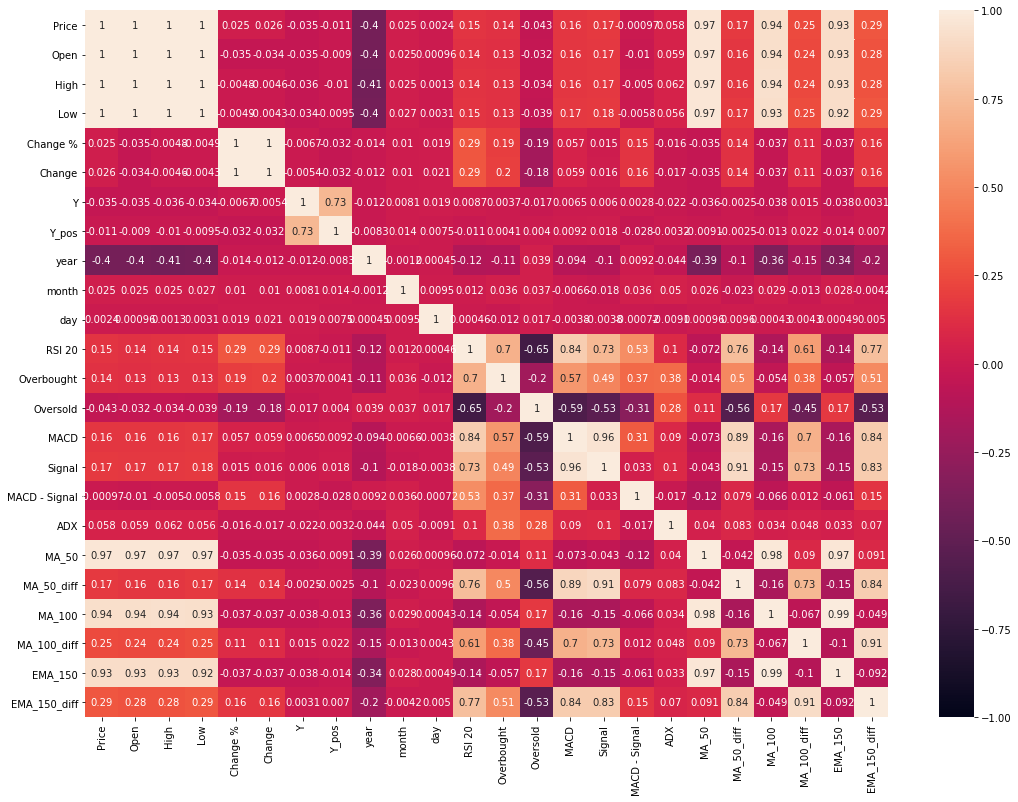

In [626]:
f, ax = plt.subplots(figsize=(18, 13))
sns.heatmap(data.corr(),annot=True,vmin=-1, vmax=1)